# Import Libraries and Load Datasets

In [3]:
import pandas as pd
import numpy as np
import re
from bs4 import BeautifulSoup
from transformers import pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Load datasets
datasets = {
    "politifact_real": "politifact_real.csv",
    "politifact_fake": "politifact_fake.csv",
    "gossipcop_real": "gossipcop_real.csv",
    "gossipcop_fake": "gossipcop_fake.csv"
}

# Load and concatenate datasets
dfs = []
for label, filepath in datasets.items():
    df = pd.read_csv(filepath)
    df['label'] = 1 if 'real' in label else 0  # 1 for real, 0 for fake
    df['source'] = label.split('_')[0]  # Source (politifact or gossipcop)
    dfs.append(df)

df = pd.concat(dfs, ignore_index=True)

# Explore the dataset
print("Combined Dataset Info:")
print(df.info())
print("\nSample Data:")
print(df.head())


None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


Combined Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23196 entries, 0 to 23195
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         23196 non-null  object
 1   news_url   22866 non-null  object
 2   title      23196 non-null  object
 3   tweet_ids  21695 non-null  object
 4   label      23196 non-null  int64 
 5   source     23196 non-null  object
dtypes: int64(1), object(5)
memory usage: 1.1+ MB
None

Sample Data:
                id                                           news_url  \
0  politifact14984                          http://www.nfib-sbet.org/   
1  politifact12944  http://www.cq.com/doc/newsmakertranscripts-494...   
2    politifact333  https://web.archive.org/web/20080204072132/htt...   
3   politifact4358  https://web.archive.org/web/20110811143753/htt...   
4    politifact779  https://web.archive.org/web/20070820164107/htt...   

                                               ti

# Text Preprocessing

In [5]:
# Function to clean text
def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = BeautifulSoup(text, "html.parser").get_text()  # Remove HTML tags
    text = re.sub(r"[^\w\s]", "", text)  # Remove special characters
    text = text.lower()  # Normalize text
    return text

# Apply cleaning to the 'title' column
df['cleaned_title'] = df['title'].apply(clean_text)

print("Cleaned Titles:")
print(df[['title', 'cleaned_title']].head())


C:\Users\Nitin Gangwar\AppData\Local\Temp\ipykernel_21068\553741318.py:5: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()  # Remove HTML tags


Cleaned Titles:
                                               title  \
0        National Federation of Independent Business   
1                        comments in Fayetteville NC   
2  Romney makes pitch, hoping to close deal : Ele...   
3  Democratic Leaders Say House Democrats Are Uni...   
4    Budget of the United States Government, FY 2008   

                                       cleaned_title  
0        national federation of independent business  
1                        comments in fayetteville nc  
2  romney makes pitch hoping to close deal  elect...  
3  democratic leaders say house democrats are uni...  
4     budget of the united states government fy 2008  


# Named Entity Recognition (NER)

In [6]:
def extract_entities(text):
    entities = {"ORG": 0, "GPE": 0, "PERSON": 0}
    if not isinstance(text, str):
        return entities
    try:
        ner_results = ner_pipeline(text)
        for entity in ner_results:
            if entity['entity_group'] in entities:
                entities[entity['entity_group']] += 1
    except Exception as e:
        print(f"Error processing text: {text}, Error: {e}")
    return entities
df['tweet_count'] = df['tweet_ids'].apply(lambda x: len(x.split(',')) if pd.notnull(x) else 0)

In [7]:
# extract the data
df['tweet_count']

0        1
1        1
2        0
3        0
4        1
        ..
23191    1
23192    1
23193    1
23194    1
23195    1
Name: tweet_count, Length: 23196, dtype: int64

In [8]:
# Apply NER to the cleaned titles
df['entities'] = df['cleaned_title'].apply(extract_entities)

# Check that the 'entities' column exists and has valid data
print(df[['cleaned_title', 'entities']].head())

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [9]:
# chhose  the color for HeatMap
{'ORG': 1, 'GPE': 0, 'PERSON': 0}

{'ORG': 1, 'GPE': 0, 'PERSON': 0}

   org_count  gpe_count  person_count
0          0          0             0
1          0          0             0
2          0          0             0
3          0          0             0
4          0          0             0


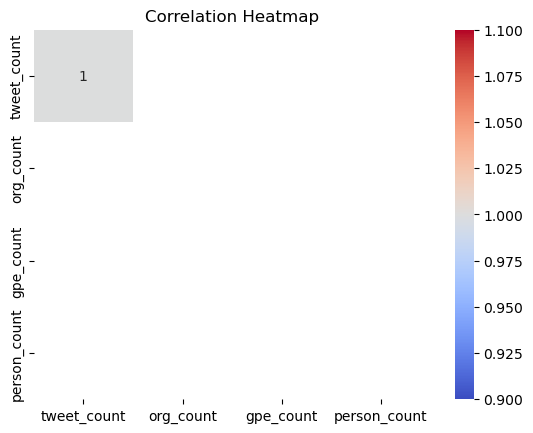

In [10]:
# Extract the counts of ORG, GPE, and PERSON
df['org_count'] = df['entities'].apply(lambda x: x.get('ORG', 0))
df['gpe_count'] = df['entities'].apply(lambda x: x.get('GPE', 0))
df['person_count'] = df['entities'].apply(lambda x: x.get('PERSON', 0))

# Check the counts
print(df[['org_count', 'gpe_count', 'person_count']].head())

# Compute correlation
correlation_data = df[['tweet_count', 'org_count', 'gpe_count', 'person_count']].corr()

# Plot the heatmap
sns.heatmap(correlation_data, annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()



# Popularity Analysis



In [11]:
# Derive popularity from tweet IDs
df['tweet_count'] = df['tweet_ids'].apply(lambda x: len(x.split(',')) if isinstance(x, str) else 0)

# Define popularity threshold
popularity_threshold = df['tweet_count'].median()
df['is_popular'] = df['tweet_count'] > popularity_threshold

print("Popularity Analysis:")
print(df[['title', 'tweet_count', 'is_popular']].head())


Popularity Analysis:
                                               title  tweet_count  is_popular
0        National Federation of Independent Business            1       False
1                        comments in Fayetteville NC            1       False
2  Romney makes pitch, hoping to close deal : Ele...            0       False
3  Democratic Leaders Say House Democrats Are Uni...            0       False
4    Budget of the United States Government, FY 2008            1       False



# Fake News Classification

In [12]:
# Use the 'label' column for fake/real classification (already encoded)
print("Fake News Classification:")
print(df[['title', 'label']].head())


Fake News Classification:
                                               title  label
0        National Federation of Independent Business      1
1                        comments in Fayetteville NC      1
2  Romney makes pitch, hoping to close deal : Ele...      1
3  Democratic Leaders Say House Democrats Are Uni...      1
4    Budget of the United States Government, FY 2008      1


# Correlation Analysis

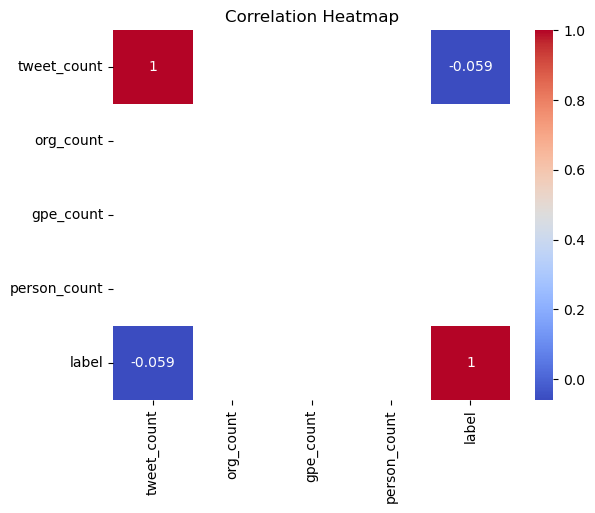

In [13]:
# Compute correlation between features
correlation_data = df[['tweet_count', 'org_count', 'gpe_count', 'person_count', 'label']].corr()

# Visualize correlation using a heatmap
sns.heatmap(correlation_data, annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


# Predictive Modeling

Classification Report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      4640

    accuracy                           1.00      4640
   macro avg       1.00      1.00      1.00      4640
weighted avg       1.00      1.00      1.00      4640



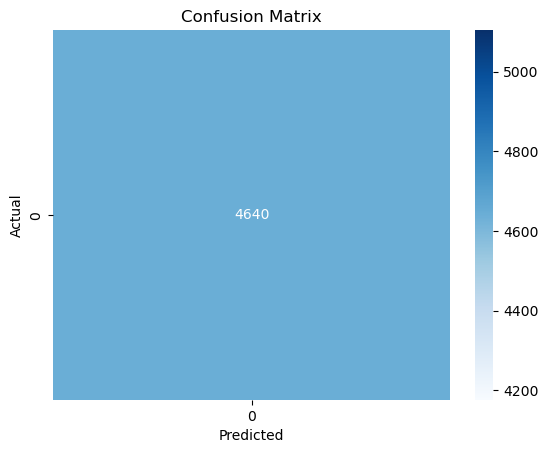

In [14]:
# Prepare features and labels
features = df[['org_count', 'gpe_count', 'person_count', 'label']]
labels = df['is_popular']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Train a Random Forest classifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# Visualization and Insights

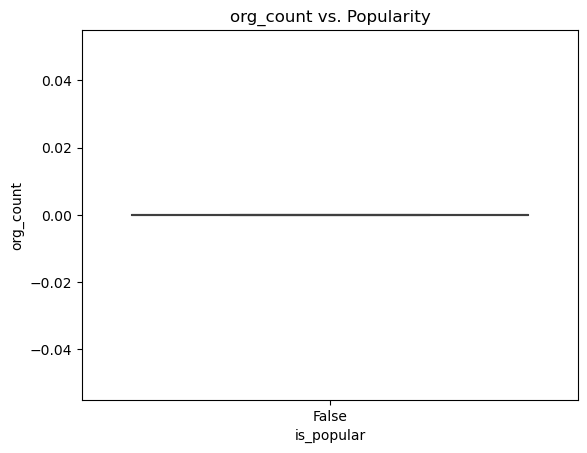

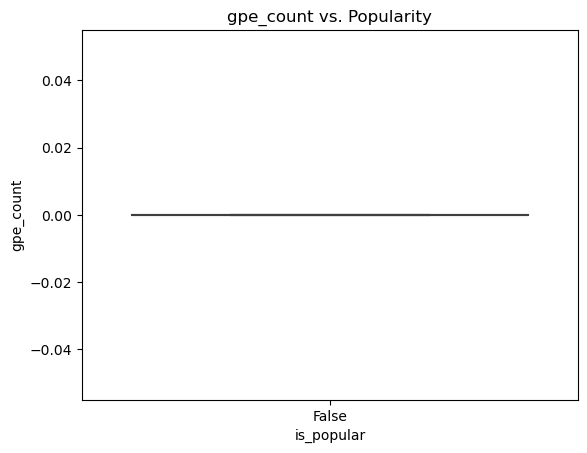

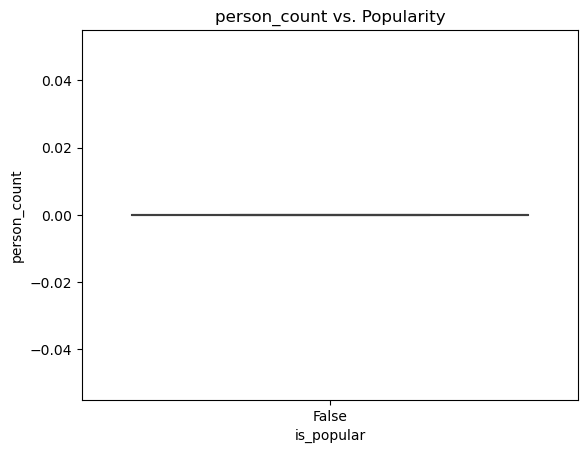

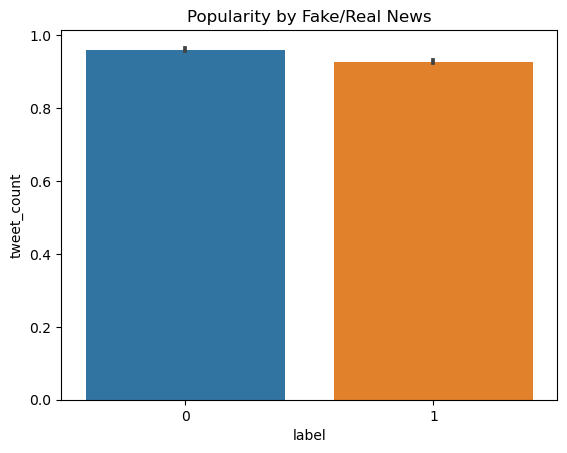

In [15]:
# Entity frequency by popularity
entity_cols = ['org_count', 'gpe_count', 'person_count']
for col in entity_cols:
    sns.boxplot(x='is_popular', y=col, data=df)
    plt.title(f"{col} vs. Popularity")
    plt.show()

# Fake vs Real Popularity Distribution
sns.barplot(x='label', y='tweet_count', data=df)
plt.title("Popularity by Fake/Real News")
plt.show()
